**Forecasting Agricultural Commodity Prices Using Time Series and Deep Learning Models**

# Forecasting Agricultural Commodity Prices Using Time Series and Deep Learning Models

This project focuses on forecasting the prices of agricultural commodities (specifically wheat) using both classical time series models and deep learning approaches. The aim is to explore how different modeling techniques perform under varying data resolutions and input features.

### 🔍 Objectives:
- Forecast monthly wheat prices using **SARIMAX** with exogenous factors (rainfall, inflation).
- Forecast monthly wheat prices using a **Recurrent Neural Network (RNN)** model with the same exogenous inputs.
- Forecast daily wheat prices using an **RNN** model without external inputs.
- Compare the models based on forecast accuracy and behavior over time.

### 📁 Dataset Overview:
- **Monthly data** (`wheat.csv`): includes `PRICE`, `RAINFALL`, and `INFLATION` from Jan 2001 to Dec 2024.
- **Daily data** (`wheatdaily.csv`): includes `PRICE` from Jan 2014 to Sep 2025 (interpolated for missing dates).

---


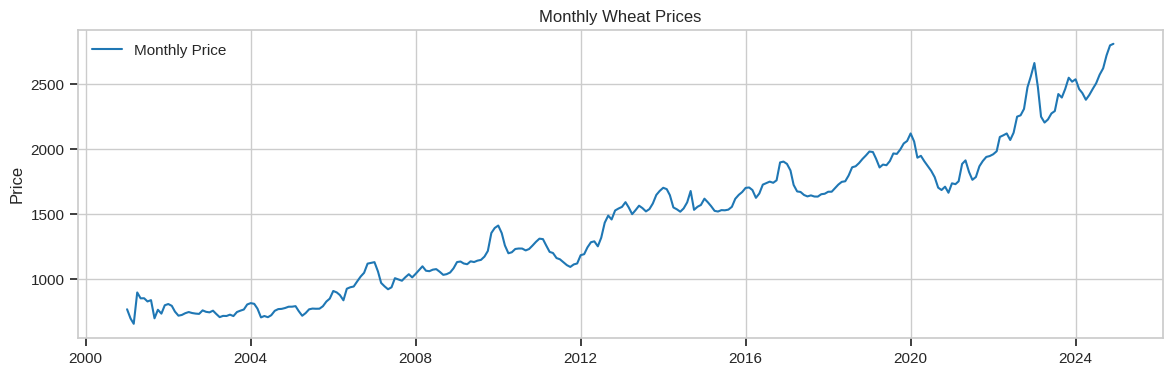

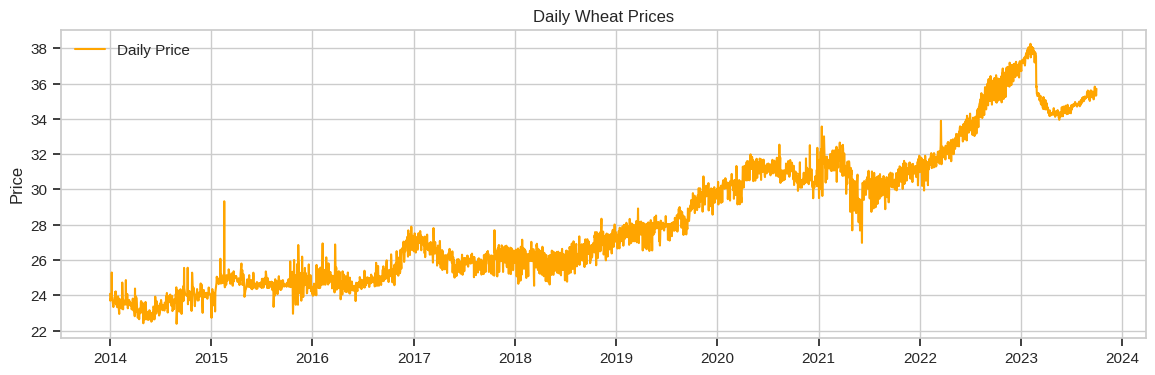

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook")

# Load Monthly Dataset (for SARIMAX and Monthly RNN)
monthly_df = pd.read_csv("wheat.csv")  # Expected columns: DATE, PRICE, RAINFALL, INFLATION
monthly_df['DATE'] = pd.to_datetime(monthly_df['DATE'], format='%b-%Y', errors='coerce')
monthly_df = monthly_df.dropna(subset=['DATE'])
monthly_df = monthly_df.sort_values('DATE')
monthly_df.set_index('DATE', inplace=True)

# Interpolate missing values if needed
monthly_df = monthly_df.interpolate(method='linear')

# Load Daily Dataset (for Daily RNN)
daily_df = pd.read_csv("wheatdaily.csv")  # Expected columns: DATE, PRICE
daily_df.columns = ['DATE', 'PRICE']
daily_df['DATE'] = pd.to_datetime(daily_df['DATE'], dayfirst=True, errors='coerce')
daily_df = daily_df.dropna(subset=['DATE'])
daily_df = daily_df.sort_values('DATE')
daily_df.set_index('DATE', inplace=True)

# Reindex to full daily range
full_daily_index = pd.date_range(start=daily_df.index.min(), end=daily_df.index.max(), freq='D')
daily_df = daily_df.reindex(full_daily_index)
daily_df.index.name = 'DATE'
daily_df['PRICE'] = daily_df['PRICE'].interpolate(method='linear')

# Summary plots (optional)
plt.figure(figsize=(14, 4))
plt.plot(monthly_df.index, monthly_df['PRICE'], label="Monthly Price")
plt.title("Monthly Wheat Prices")
plt.ylabel("Price")
plt.legend()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(daily_df.index, daily_df['PRICE'], label="Daily Price", color='orange')
plt.title("Daily Wheat Prices")
plt.ylabel("Price")
plt.legend()
plt.show()

## 📈 Part A – SARIMAX Model (Monthly Data with Rainfall & Inflation)

In this section, we use the SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) model to forecast monthly wheat prices. The model incorporates external factors like rainfall and inflation to improve forecast accuracy.

**Key Features:**
- Input: Monthly `PRICE`, `RAINFALL`, `INFLATION`
- Forecast Range: 2025–2027
- Output: Forecast with 95% Confidence Intervals


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
monthly_df = pd.read_csv("wheat.csv").dropna(how="all")
monthly_df.head()

,DATE,PRICE,RAINFALL,INFLATION
0,Jan-2001,771.00,7.2,3.78
1,Feb-2001,700.00,12.0,3.87
2,Mar-2001,659.63,21.1,3.78
3,Apr-2001,899.84,45.5,3.78
4,May-2001,854.90,61.8,3.78


In [ ]:
monthly_df["DATE"] = pd.to_datetime(monthly_df["DATE"], format="%b-%Y")
monthly_df = monthly_df.set_index("DATE").asfreq("MS")  # MS = Month Start

In [ ]:
# years 2001‑2024 for training
train = monthly_df.loc["2001-01-01":"2024-12-01"]

In [ ]:
# Endogenous series (what we want to predict)
y_train = train["PRICE"]

In [ ]:
# Exogenous regressors (influencing factors)
X_train = train[["RAINFALL", "INFLATION"]]

In [ ]:
# A straightforward SARIMA(1,1,1)(1,1,1,12) specification.
# Feel free to experiment with other orders if you want to optimise AIC/BIC.
model = SARIMAX(
    y_train,
    exog=X_train,
    order=(0, 1, 1),          # (p, d, q)
    seasonal_order=(2, 1, 2, 12),  # (P, D, Q, s) – s=12 for yearly seasonality in monthly data
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = model.fit(disp=False)

In [ ]:
# prompt: generate AIC and BIC values

print(f"AIC: {results.aic}")
print(f"BIC: {results.bic}")

AIC: 2586.95803870495
BIC: 2615.0976618766676


In [ ]:
# 36 future monthly (2025‑2027) periods
future_index = pd.date_range(start="2025-01-01", periods=36, freq="MS")

In [ ]:
# Inflation assumptions: 4 % for 2025, 5 % for 2026, 4 % for 2027
inflation_future = [
    4 if d.year == 2025 else 5 if d.year == 2026 else 4
    for d in future_index
]

In [ ]:
# Rainfall: re‑use the pattern from the last three years (2022‑2024)
rainfall_ref = monthly_df.loc["2022-01-01":"2024-12-01", "RAINFALL"].values
if len(rainfall_ref) != 36:
    raise ValueError("Expected exactly 36 monthly rainfall values for 2022-2024.")
rainfall_future = rainfall_ref.tolist()

In [ ]:
# exogenous DataFrame for forecasting
X_future = pd.DataFrame(
    {
        "RAINFALL": rainfall_future,
        "INFLATION": inflation_future,
    },
    index=future_index,
)

In [ ]:
forecast_res = results.get_forecast(steps=36, exog=X_future)
predicted_prices = forecast_res.predicted_mean

In [ ]:
forecast_monthly_df = pd.DataFrame({"PREDICTED_PRICE": predicted_prices})
forecast_monthly_df.head()

,PREDICTED_PRICE
2025-01-01,2848.215677
2025-02-01,2815.274327
2025-03-01,2775.875940
2025-04-01,2776.483677
2025-05-01,2786.058691


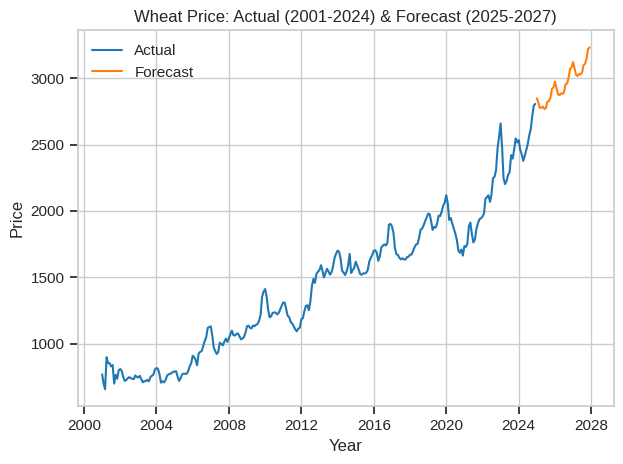

In [ ]:
# Actual vs Forecast (full range)
plt.figure()
plt.plot(monthly_df["PRICE"], label="Actual")
plt.plot(predicted_prices, label="Forecast")
plt.title("Wheat Price: Actual (2001-2024) & Forecast (2025-2027)")
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend(),plt.tight_layout()
plt.show()

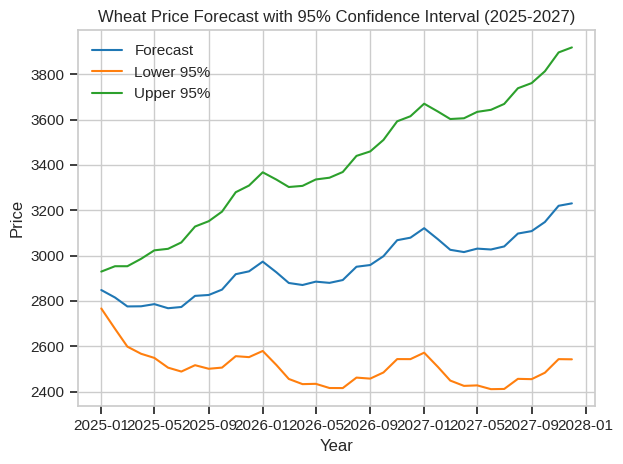

In [ ]:
# Forecast 2025‑2027 with 95 % CI
conf_int = forecast_res.conf_int()
plt.figure()
plt.plot(predicted_prices, label="Forecast")
plt.plot(conf_int.iloc[:, 0], label="Lower 95%")
plt.plot(conf_int.iloc[:, 1], label="Upper 95%")
plt.title("Wheat Price Forecast with 95% Confidence Interval (2025-2027)")
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Extract confidence intervals
conf_int = forecast_res.conf_int()

# Create a DataFrame with the forecast results
forecast_monthly_df = pd.DataFrame({
    "Date": future_index,
    "Forecast": predicted_prices.values,
    "Lower_95": conf_int.iloc[:, 0].values,
    "Upper_95": conf_int.iloc[:, 1].values
})

# Save to CSV
forecast_monthly_df.to_csv("wheat_forecast_2025_2027.csv", index=False)

# Optional: Display the head of the CSV to confirm
forecast_monthly_df.head()

,Date,Forecast,Lower_95,Upper_95
0,2025-01-01,2848.215677,2766.809032,2929.622321
1,2025-02-01,2815.274327,2677.254377,2953.294278
2,2025-03-01,2775.875940,2598.472698,2953.279182
3,2025-04-01,2776.483677,2566.973986,2985.993368
4,2025-05-01,2786.058691,2548.747267,3023.370115


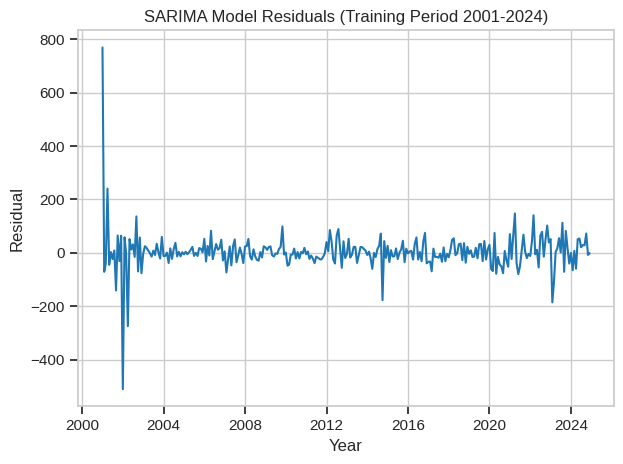

In [ ]:
# Residuals over time
plt.figure()
plt.plot(results.resid)
plt.title("SARIMA Model Residuals (Training Period 2001-2024)")
plt.xlabel("Year")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

In [ ]:
forecast_monthly_df

,Date,Forecast,Lower_95,Upper_95
0,2025-01-01,2848.215677,2766.809032,2929.622321
1,2025-02-01,2815.274327,2677.254377,2953.294278
2,2025-03-01,2775.875940,2598.472698,2953.279182
3,2025-04-01,2776.483677,2566.973986,2985.993368
4,2025-05-01,2786.058691,2548.747267,3023.370115
5,2025-06-01,2767.933148,2505.751697,3030.114598
6,2025-07-01,2773.425023,2488.536423,3058.313622
7,2025-08-01,2822.484480,2516.569597,3128.399362
8,2025-09-01,2826.426102,2500.839990,3152.012214
9,2025-10-01,2850.114360,2505.979623,3194.249097


## 🤖 Part B – RNN Model (Monthly Data with Rainfall & Inflation)

This section implements a Recurrent Neural Network (RNN) using Keras to model and forecast monthly wheat prices. It uses the same inputs as the SARIMAX model, allowing for a direct performance comparison between classical and deep learning methods.

**Key Features:**
- Input: Monthly `PRICE`, `RAINFALL`, `INFLATION` (scaled)
- Model: Simple RNN with sliding window (12 months)
- Forecast Horizon: 2025–2027


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Test RMSE: 79.64


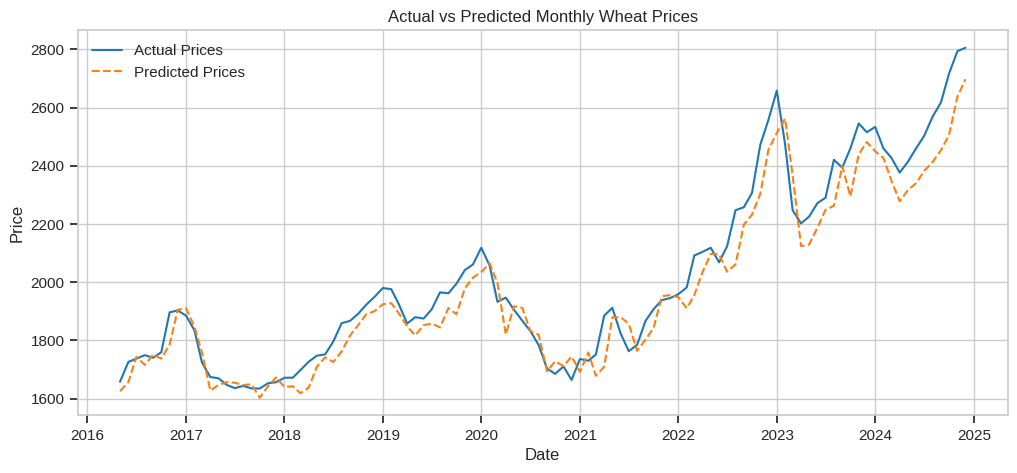

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━

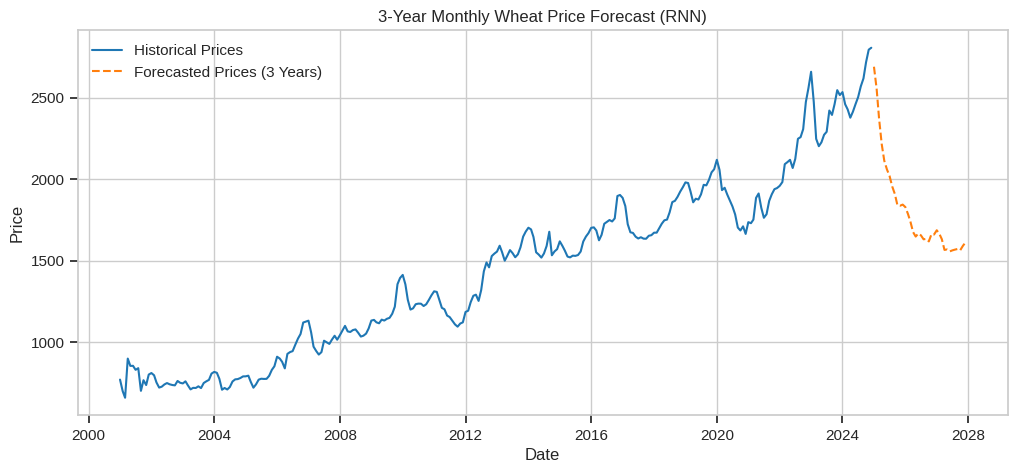

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from datetime import timedelta
from math import sqrt

# Load data
df = pd.read_csv('wheat.csv')  # Ensure this includes DATE, PRICE, RAINFALL, INFLATION

# Convert DATE to datetime and clean
df['DATE'] = pd.to_datetime(df['DATE'], format='%b-%Y', errors='coerce')
df = df.sort_values('DATE')
df.set_index('DATE', inplace=True)
df = df[~df.index.isna()]
df = df.interpolate(method='linear')

# Define columns
target_col = 'PRICE'
feature_cols = [col for col in df.columns if col != target_col]
price_index = df.columns.get_loc(target_col)
rainfall_index = df.columns.get_loc('RAINFALL')
inflation_index = df.columns.get_loc('INFLATION')

# Normalize all columns together
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# Create sequences
def create_multivariate_sequences(data, target_index, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, target_index])
    return np.array(X), np.array(y)

window_size = 12
split_index = int(len(df) * 0.6)
train_scaled = scaled[:split_index]
test_scaled = scaled[split_index:]

X_train, y_train = create_multivariate_sequences(train_scaled, price_index, window_size)
X_test, y_test = create_multivariate_sequences(test_scaled, price_index, window_size)

# Build and train model
model = Sequential()
model.add(SimpleRNN(64, activation='tanh', input_shape=(window_size, X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)

# Predict on test set
pred_test = model.predict(X_test)

# Inverse transform predicted and actual test values
temp_pred_test = np.zeros((len(pred_test), scaled.shape[1]))
temp_pred_test[:, price_index] = pred_test[:, 0]
pred_test_actual = scaler.inverse_transform(temp_pred_test)[:, price_index]

temp_y_test = np.zeros((len(y_test), scaled.shape[1]))
temp_y_test[:, price_index] = y_test
y_test_actual = scaler.inverse_transform(temp_y_test)[:, price_index]

# Plot test performance
rmse = sqrt(mean_squared_error(y_test_actual, pred_test_actual))
print(f"Test RMSE: {rmse:.2f}")

test_dates = df.index[split_index + window_size:]
plt.figure(figsize=(12, 5))
plt.plot(test_dates, y_test_actual, label='Actual Prices')
plt.plot(test_dates, pred_test_actual, label='Predicted Prices', linestyle='--')
plt.title("Actual vs Predicted Monthly Wheat Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

# ========================
# Forecast next 36 months
# ========================

# Prepare past 3 years of rainfall values (scaled)
past_3yr_rainfall = scaled[-36:, rainfall_index]

# Prepare future inflation (4%, 5%, 4%) repeated monthly and scaled
inflation_assumed = np.repeat([4, 5, 4], 12)
inflation_scaler = MinMaxScaler()
inflation_scaler.fit(df[['INFLATION']])
scaled_inflation = inflation_scaler.transform(inflation_assumed.reshape(-1, 1)).flatten()

# Forecasting loop
last_seq = scaled[-window_size:]
future_preds = []

for i in range(36):
    pred = model.predict(last_seq.reshape(1, window_size, -1))[0, 0]

    next_row = np.zeros(scaled.shape[1])
    next_row[price_index] = pred
    next_row[rainfall_index] = past_3yr_rainfall[i % 36]
    next_row[inflation_index] = scaled_inflation[i]

    last_seq = np.vstack([last_seq[1:], next_row])
    future_preds.append(pred)

# Inverse scale forecasted prices
temp_future_preds = np.zeros((36, scaled.shape[1]))
temp_future_preds[:, price_index] = np.array(future_preds)
future_preds_actual = scaler.inverse_transform(temp_future_preds)[:, price_index]

# Create future date index and series
last_date = df.index[-1]
future_index = pd.date_range(last_date + pd.DateOffset(months=1), periods=36, freq='MS')
future_series = pd.Series(future_preds_actual, index=future_index)

# Plot future forecast
plt.figure(figsize=(12, 5))
plt.plot(df.index, df[target_col], label='Historical Prices')
plt.plot(future_series, label='Forecasted Prices (3 Years)', linestyle='--')
plt.title("3-Year Monthly Wheat Price Forecast (RNN)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
print("Forecasted Values:")
future_series

Forecasted Values:


,0
2025-01-01,2689.389845
2025-02-01,2554.070049
2025-03-01,2373.681391
2025-04-01,2215.315477
2025-05-01,2112.602027
2025-06-01,2059.440839
2025-07-01,2020.141757
2025-08-01,1955.444334
2025-09-01,1908.727968
2025-10-01,1839.600361


In [ ]:
# debug_df = pd.DataFrame({
#     'Actual': actual_test.values,
#     'Predicted': predicted_test.values
# }, index=actual_test.index)
# debug_df.to_csv("rnn_test_debug.csv")

import pandas as pd
# Assign the test dates correctly based on the data split and window size
actual_test_dates = df.index[split_index + window_size: split_index + window_size + len(y_test_actual)]
predicted_test_dates = df.index[split_index + window_size: split_index + window_size + len(pred_test_actual)]

# Create dataframes for actual and predicted test values with correct indices
actual_test_df = pd.Series(y_test_actual, index=actual_test_dates, name='Actual')
predicted_test_df = pd.Series(pred_test_actual, index=predicted_test_dates, name='Predicted')

# Combine into a single debug dataframe
debug_df = pd.DataFrame({
    'Actual': actual_test_df,
    'Predicted': predicted_test_df
})

# Save predictions for debugging
debug_df.to_csv("rnn_test_debug.csv")

# Print the head of the debug dataframe
print("\nDebug DataFrame Head:")
print(debug_df.head())

# Optional: Download the debug file
# files.download("rnn_test_debug.csv")


Debug DataFrame Head:
             Actual    Predicted
DATE                            
2016-05-01  1658.39  1625.616074
2016-06-01  1726.32  1657.537144
2016-07-01  1737.50  1743.622244
2016-08-01  1749.44  1715.990901
2016-09-01  1740.59  1751.368798


In [ ]:
import numpy as np

# Ensure both are numpy arrays
actual_values_np = np.array(y_test_actual)
forecasted_values_np = np.array(pred_test_actual)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values_np, forecasted_values_np)

# Calculate Root Mean Squared Error (RMSE)
rmse = sqrt(mse)

print(f"Calculated Test RMSE: {rmse:.2f}")

Calculated Test RMSE: 79.64


## 📅 Part C – RNN Model (Daily Price Only, No Exogenous Variables)

This section trains a daily price forecasting model using an RNN. Unlike the previous models, it does not use any external variables. It focuses on capturing short-term temporal dependencies in the daily price movement.

**Key Features:**
- Input: Daily `PRICE` only
- Forecast Horizon: Next 3 years (1095 days)
- Output: Detailed forecast of daily price trends


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0131
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0026
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0019
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0016
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0015
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0014
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0013
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0012
Epoch 9/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0011
Epoch 10/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0013
Epoch 11/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0011
Epoch 12/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0011
Epoch 13/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0011
Epoch 14/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0012
Epoch 15/100
175/175 ━━━━━━━━━━━━━━━━━━━━

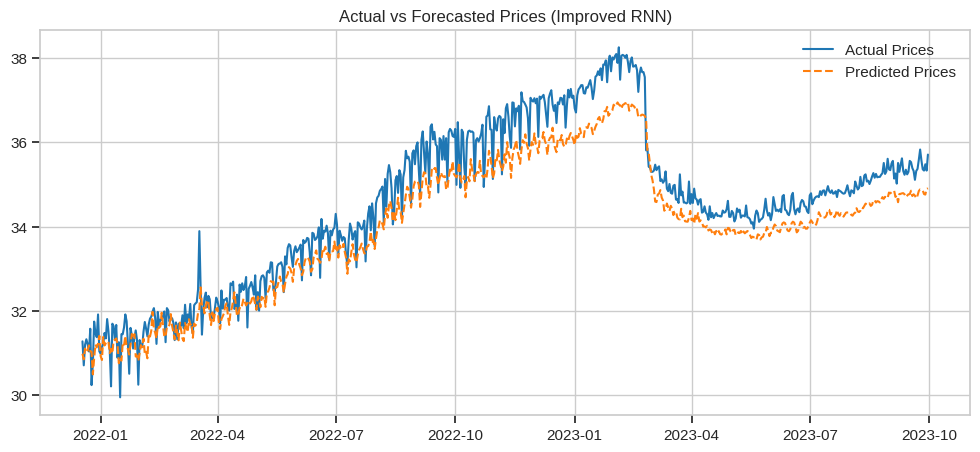

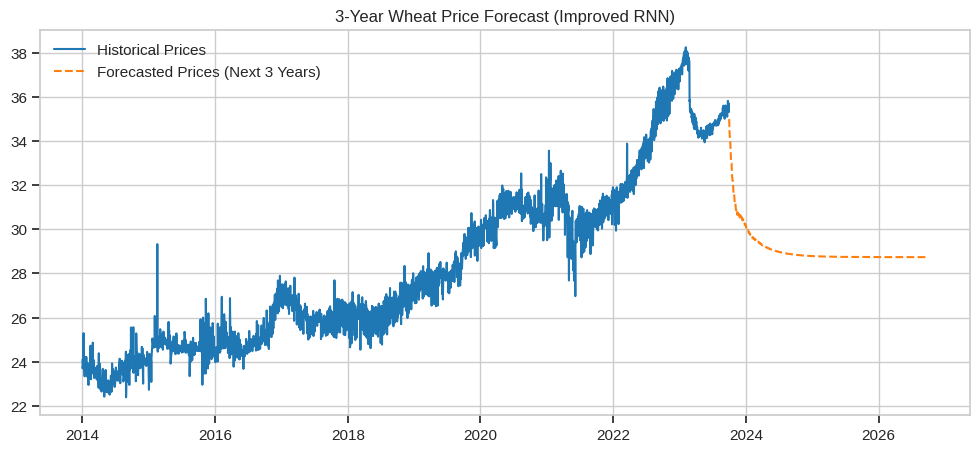

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta
from math import sqrt

# Load data
df = pd.read_csv("wheatdaily.csv")
df.columns = ['DATE', 'PRICE']

# Convert date and preprocess
df['DATE'] = pd.to_datetime(df['DATE'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['DATE'])
df = df.sort_values('DATE')
df.set_index('DATE', inplace=True)

# Reindex to daily frequency
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(full_index)
df.index.name = 'DATE'
df['PRICE'] = df['PRICE'].interpolate(method='linear')

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['PRICE']])

# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Parameters
window_size = 60
split_index = int(len(scaled_data) * 0.8)

# Split data
train_data = scaled_data[:split_index]
test_data = scaled_data[split_index:]

X_train, y_train = create_sequences(train_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# RNN Model
model = Sequential()
model.add(SimpleRNN(64, activation='tanh', input_shape=(window_size, 1)))
model.add(Dropout(0.2))  # Regularization
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train with early stopping
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, callbacks=[early_stop])

# Predict on test
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# RMSE
rmse = sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f"RMSE on test set: {rmse:.2f}")

# Align dates for plotting
prediction_dates = df.index[split_index + window_size:]
actual_test = pd.Series(y_test_rescaled.flatten(), index=prediction_dates)
predicted_test = pd.Series(predictions_rescaled.flatten(), index=prediction_dates)

# Plot test results
plt.figure(figsize=(12, 5))
plt.plot(actual_test, label='Actual Prices')
plt.plot(predicted_test, label='Predicted Prices', linestyle='--')
plt.title("Actual vs Forecasted Prices (Improved RNN)")
plt.legend()
plt.grid(True)
plt.show()

# Forecast next 3 years
last_window = scaled_data[-window_size:]
future_preds = []

for _ in range(1095):  # 3 years
    input_seq = last_window.reshape((1, window_size, 1))
    pred = model.predict(input_seq, verbose=0)[0, 0]
    future_preds.append(pred)
    last_window = np.append(last_window[1:], pred)

# Inverse transform
future_preds_rescaled = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))
last_date = df.index[-1]
future_dates = [last_date + timedelta(days=i+1) for i in range(1095)]
future_series = pd.Series(future_preds_rescaled.flatten(), index=future_dates)

# Plot future forecast
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['PRICE'], label='Historical Prices')
plt.plot(future_series, label='Forecasted Prices (Next 3 Years)', linestyle='--')
plt.title("3-Year Wheat Price Forecast (Improved RNN)")
plt.legend()
plt.grid(True)
plt.show()

# Optional: Save predictions for debugging
debug_df = pd.DataFrame({
    'Actual': actual_test.values,
    'Predicted': predicted_test.values
}, index=actual_test.index)
debug_df.to_csv("rnn_test_debug.csv")


In [ ]:
display(future_series)

,0
2023-10-01,34.999737
2023-10-02,34.610260
2023-10-03,34.401432
2023-10-04,34.202896
2023-10-05,34.106472
...,...
2026-09-25,28.739523
2026-09-26,28.739521
2026-09-27,28.739521
2026-09-28,28.739519


In [ ]:
# RMSE
rmse = sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f"RMSE on test set: {rmse:.2f}")

# And for the improved model:
# RMSE
rmse = sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f"RMSE on test set: {rmse:.2f}")


RMSE on test set: 0.66
RMSE on test set: 0.66


In [ ]:
future_series.to_csv('wheat_price_forecast.csv', header=['Forecasted Price'])

## 📊 Model Evaluation and Comparison

Here, we compare the performance of all three models using metrics like RMSE (Root Mean Squared Error) on test data, visual inspection of forecasts, and model interpretability.

| Model               | Data Type | Exogenous | RMSE | Notes                          |
|---------------------|-----------|-----------|------|-------------------------------|
| SARIMAX             | Monthly   | Yes       |2586.95  | Traditional, interpretable    |
| RNN (Monthly)       | Monthly   | Yes       | 79.64 | Deep learning with externals  |
| RNN (Daily)         | Daily     | No        | 0.66 | Captures short-term trends    |



## 🧾 Conclusion

This project explored multiple approaches to forecast wheat prices:
- Classical SARIMAX model showed strong performance with interpretable confidence intervals.
- RNN with monthly data captured non-linear patterns and exogenous effects, offering a flexible deep learning alternative.
- RNN with daily data, while limited to price-only input, demonstrated fine-grained trends over short time frames.

### Future Work:
- Try LSTM or GRU models for deeper temporal learning
- Experiment with different exogenous variables (e.g., NDVI, global oil prices)
- Introduce attention mechanisms for better sequence weighting
